# Lab 9: Twitter data analysis  

In this lab, we will learn how to read JSON files and how to perform exploratory analysis of twitter data. As an extra credit, you will learn how to use API to download tweets on the topic of your choice.

Let us start by importing the needed packages.

In [181]:
import json
import random
import time
import calendar
import codecs
import datetime
import sys
import gzip
import string
import glob
import os
import numpy as np
import dateutil.parser

## Module 0: Reading Tweets

Tweets are saved in the form of a JSON file. Open `onetweet` file in a text editor and study how it looks. This file contains information from a single tweet. The file is written in the JSON format, which is easy for a computer to read and parse. 

**Question 1**. Google `JSON` and try to learn about this particular data format. Explain in one or two paragraphs what you learned.

Let us read `onetweet` JSON file. We will create an object and print it.

<h3><strong>
    I found the following information on https://www.w3schools.com/js/js_json_intro.asp after googling searching JSON. I found that JSON stands for, JavaScript Object Notation. JSON is a syntax for storing and exchanging data, It is text, written using JavaScript object notation.<br><br>Additionally, when exchanging data between a browser and a server, the data can only be text. We can convert any JavaScript object into JSON, and send JSON to the server. We can also convert any JSON received from the server into JavaScript objects. This way we can work with the data as JavaScript objects, with no complicated parsing and translations.
    </strong></h3>

In [182]:
from pprint import pprint
tweet = json.load(open('onetweet', 'rb'))
pprint (tweet)

{u'_id': u'264230205529411585',
 u'contributors': None,
 u'coordinates': {u'coordinates': [-73.95639896, 40.71411847],
                  u'type': u'Point'},
 u'created_at': u'2012-11-02T04:59:24',
 u'disaster': u'2012_sandy_hurricane_en',
 u'entities': {u'hashtags': [],
               u'symbols': [],
               u'urls': [{u'display_url': u'instagr.am/p/Rg70o6xlkY/',
                          u'expanded_url': u'http://instagr.am/p/Rg70o6xlkY/',
                          u'indices': [33, 53],
                          u'url': u'http://t.co/G0LdsQAz'}],
               u'user_mentions': []},
 u'favorite_count': 0,
 u'favorited': False,
 u'geo': {u'coordinates': [40.71411847, -73.95639896], u'type': u'Point'},
 u'id': u'264230205529411585',
 u'id_str': u'264230205529411585',
 u'in_reply_to_screen_name': None,
 u'in_reply_to_status_id': None,
 u'in_reply_to_status_id_str': None,
 u'in_reply_to_user_id': None,
 u'in_reply_to_user_id_str': None,
 u'is_quote_status': False,
 u'lang': u'en',

As we can see, each tweet is stored in a dictionary. Although there are more than 20 different keys in the dictionary, we introduce the most important fields which will be used in the rest of this lab.
<ul>
<li>'_id': shows the unique id of this tweet.</li>

<li>'coordinates': shows the location from which the tweet was posted. The field might be null if the tweet contains no location data, or it could contain bounding box information, place information, or GPS coordinates in the form of (longitude, latitude). </li>

<li>'created_at': shows the time the tweet has been created.</li>

<li>'text': shows the text of the tweet.</li>

<li>'user': contains multiple dictionaries describing the user, including the name of this user, the number of followers, the number of friends...</li>
</ul>

**Question 2**. Explain 3 more keys that you find interesting

<h3><strong>
    1. 'geo': This tag also holds the coordinates, but in the correct order. I was attempting to find where the tweet was posted from by googling the latitude and longitude from 'coordinates'. The coordinates stored in that tag seem reversed, when I ran the search on the latitude and longitude google maps returned the tweet was posted on the "Antarctic Ice shield, Antarctica", obviously that couldn't be true. After looking through the tags I found the geo tag and noticed it was the reverse of 'coordinates' and found the correct tweet location after a quick google search.<br><br>
    2. 'location': I found this tag interesting/confusing because it says singapore, along with 'time_zone' which also says singapore. I thought something malfunctioned, but after searching amanda_tan on twitter I now understand why it says singapore. (because that's her location on twitter)<br><br>
    3. 'verified': I found this tag really revealing, I never thought about the fact that the verified check could be stored in a boolean variable, so that was kind of eye opening.<br>
    </strong>
    </h3>

In the following code we will load around 4,000 tweets sent from New York City region during Sandy Hurricane from a JSON file `myNYC.json`. As part of this process, we will extract each tweet's post time and create a time series of the number of tweets in each hour during the event.

In [183]:
filePath='smallNYC.json'
localTweetList = []
globalTweetCounter = 0
frequencyMap = {}
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    
    # Try to extract the time of the tweet
    currentTime=dateutil.parser.parse(tweetObj['created_at'])
    currentTime = currentTime.replace(second=0)
    currentTime = currentTime.replace(minute=0)

    #print currentTime
    # Increment tweet count
    globalTweetCounter += 1
    
    # If our frequency map already has this time, use it, otherwise add
    if ( currentTime in frequencyMap.keys() ):
        timeMap = frequencyMap[currentTime]
        timeMap["count"] += 1
        timeMap["list"].append(tweetObj)
    else:
        frequencyMap[currentTime] = {"count":1, "list":[tweetObj]}

# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

#timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
timeIntervalStep = datetime.timedelta(hours=1)
while ( thisTime <= lastTime ):
    if ( thisTime not in frequencyMap.keys() ):
        frequencyMap[thisTime] = {"count":0, "list":[]}
        
    thisTime = thisTime + timeIntervalStep

print ("Processed Tweet Count:", globalTweetCounter)




('Processed Tweet Count:', 4295)


## Module 1: Simple Frequency Analysis

In this section, we will cover a few simple analysis techniques for EDA of the available twitter datay.

- Twitter Timeline
- Top Twitter Users
- Twitter API
- Posting Frequency Distribution
- Popular Hashtags
- Simple Event Detection
- Language Distributions

### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per hour.

('Time Frame:', datetime.datetime(2012, 10, 22, 5, 0), datetime.datetime(2012, 11, 2, 4, 0))


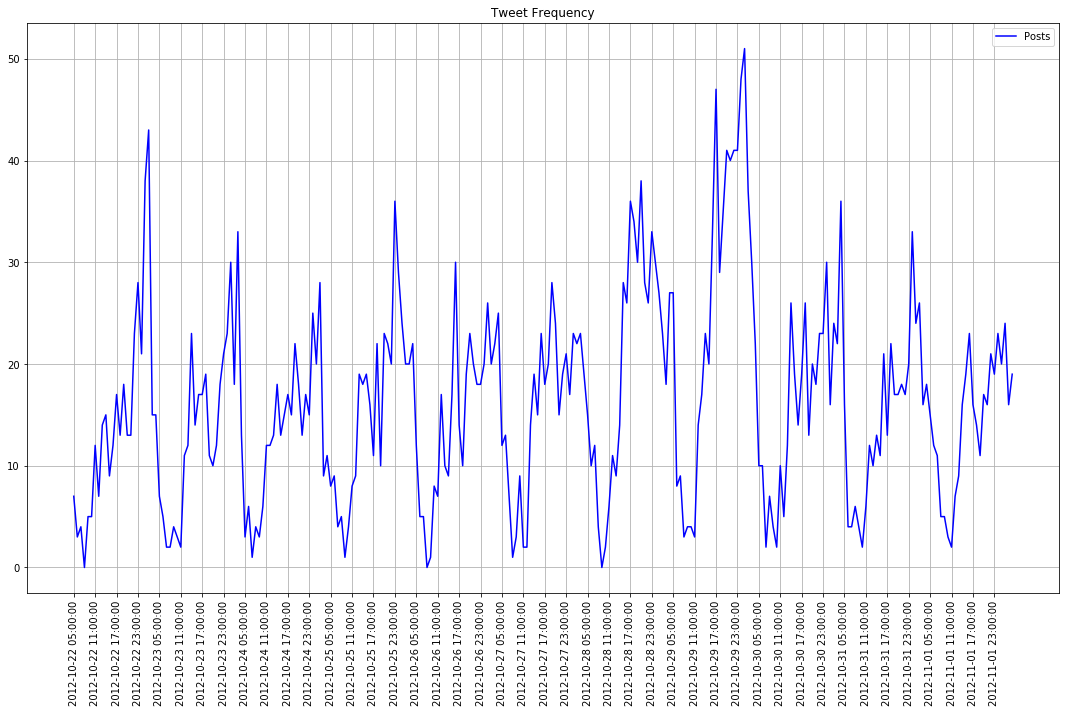

In [184]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]

# We'll have ticks every thirty minutes (much more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 6)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(frequencyMap)), [x if x > 0 else 0 for x in postFreqList], color="blue", label="Posts")
ax.grid(b=True, which=u'major')
ax.legend()

plt.show();

**Question 3**. When is the tweeting activity the largest? Find a wikipedia article about the Sandy Hurricane to understand the timeline of events surrounding it. Discuss if you see a correlation with the tweet frequencies. Select some tweets from different time points and see if the messages are correlated with the events on the ground.

<h3><strong>
    Activity was largest at 11:00 PM on 10-29-2012. Through looking at wikipedia and weather.gov (to see track of strom by day) I found that Sandy made landfall betwen the 29th and 30th, so storm conditions would've been at pretty extreme levels around 11:00 PM on the 29th.
    </strong>
    </h3>

In [256]:
PulledTweets = frequencyMap[sortedTimes[160]]['list']

for x in PulledTweets:
    print x['created_at']
    print x['text']

print "\n"
PulledTweets3 = frequencyMap[sortedTimes[213]]['list']

for x3 in PulledTweets3:
    print x3['created_at']
    print x3['text']

    
print "\n"
PulledTweets2 = frequencyMap[sortedTimes[234]]['list']

for x2 in PulledTweets2:
    print x2['created_at']
    print x2['text']

2012-10-28T21:01:29
NO SCHOOL TOMMOROW !!!!!!!!!!!!!!
2012-10-28T21:06:58
Big bobs ready for sandy! ☔ #stylin #shotdad #huntingseason  @ Evacuation Zone http://t.co/Dma7Kkdc
2012-10-28T21:11:34
@LuisJz_x12 no where cuz we have a hurricane coming for us que bobo -_-
2012-10-28T21:12:58
What the hell is duct tape on your window going to protect you from
2012-10-28T21:15:16
JPP #BIGBLUE #Cowboyssuck
2012-10-28T21:15:28
JPP!!!!!
2012-10-28T21:16:53
I love Romo
2012-10-28T21:18:34
No risk of scurvy up here! #Sandy #ZoneC  @ Upper East Side http://t.co/xiCg0OXD
2012-10-28T21:20:28
Here comes the wind and rain!
2012-10-28T21:20:44
@amandarykoff @andyglockner so that last one was a success?
2012-10-28T21:22:30
I love when @roxesque stepdad makes chilli.
2012-10-28T21:26:56
DIDN'T NEED THAT AHMAD!! C'MON D! #NYGIANTS
2012-10-28T21:27:53
The XX is off. Thanks #Sandy.
2012-10-28T21:30:12
I'm at Kaufman Management Center (New York, NY) http://t.co/rNyYyKup
2012-10-28T21:33:06
@anus_burner what hap

<h3>
    <strong>
        I printed three sections of tweets. First, I printed tweets from 2012-10-28 at roughly 21:00PM and the tweets for an hour after that point. That sections of tweets definitely show that people are concerned/dealing with side effects from the coming hurricane.
        <br><br>
        The second section I printed is from 2012-10-31 at 2:00 PM and again for an hour after that point. To my naked eye it seems like less tweets in this section were related to the hurricane. But there were definitely still tweets about very important stuff related to the hurricane. For example, someone tweeted about the number of babies born at mount Sinai during the Hurricane Sandy, New York Half in the Dark @ East River Ferry Terminal North 6th Street/North Williamsburg Landing, and "WHY IS MY INTERNET NOT WORKING ?!". While the latter of the aforementioned tweets may not necessarily be related to sandy theres a high probability it is.
        <br><br>
        The third section printed tweets from 2012-10-31 at 23:00 PM and the following hour, we can see a tweet or two related to the storm but far less than the first two sections. This shows how quickly people return to normal behavior on twitter.
    </strong>
</h3>

### Top Twitter Users

The following piece of code reveals the users that produced the most tweets. 

In [302]:
# Create maps for holding counts and tweets for each user
globalUserCounter = {}
globalUserMap = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if ( user not in globalUserCounter ):
            globalUserCounter[user] = 1
            globalUserMap[user] = [tweet]
        else:
            globalUserCounter[user] += 1
            globalUserMap[user].append(tweet)

print ("Unique Users:", len(globalUserCounter.keys()))

('Unique Users:', 3042)


In [304]:
sortedUsers = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)

print ("Top Ten Most Prolific Users:")
for u in sortedUsers[:10]:
    print u, globalUserCounter[u], "\n\t", "Random Tweet:", globalUserMap[u][0]["text"], "\n----------"   

Top Ten Most Prolific Users:
Young_Boss718 37 
	Random Tweet: That random text  I had got be for LMFAO shit was funny 
----------
Cocky_Johnny 15 
	Random Tweet: @_tinaDeex3 LMAO #Dead 
----------
frankieciv608 15 
	Random Tweet: “@JohnKincade Dear Donald Trump,
Americans &amp; Republicans chose to not involve you in this election between Prez &amp; Romney.
Please go away.” 
----------
labroides 14 
	Random Tweet: @SharkDevocean best of luck. That's awesome 
----------
ReelTalker 12 
	Random Tweet: @FilmFatale_NYC also, in other news, i totally thought it was idris who tweeted me. Saw the pic and got  excited :-) 
----------
kcastrox3 11 
	Random Tweet: Cuz this love is a sure thing. 
----------
carolsommers727 11 
	Random Tweet: @coreymach lookin spiffy 👌 
----------
Amooniac 11 
	Random Tweet: Je Hyper nul en Francais mais je sais qu'on ne dit pas le PLUS piire ! SEIGNEUR aidez moi a comprendre ce qui n'a pas marché ak @mhathe911 
----------
_LizmaryA 11 
	Random Tweet: Hey hurricane

**Question 4**. Find and print the top 10 users with the most friends. Find and print the top 10 users with the most followers. 

In [296]:
#question 4 part 1
#Find and print the top 10 users with the most friends

# Create maps for holding counts and tweets for each user
globalUserCounterQ4p1 = {}
globalUserMapQ4p1 = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        userQ4 = tweet["user"]["screen_name"]
        #userFriends = tweet["user"]["friends_count"]
        
        if ( userQ4 not in globalUserCounterQ4p1 ):
            globalUserCounterQ4p1[userQ4] = tweet["user"]["friends_count"]
            #globalUserMap[userQ4] = tweet["user"]["friends_count"]
        #else:
            #globalUserMap[userQ4] = tweet["user"]["friends_count"]
            #globalUserCounter[userQ4] += 1
            #globalUserMap[userQ4].append(tweet)

print ("Unique Users:", len(globalUserCounterQ4p1.keys()))

('Unique Users:', 3042)


In [297]:
#question 4 part 1
sortedUsersQ4p1 = sorted(globalUserCounterQ4p1, key=globalUserCounterQ4p1.get, reverse=True)

for u in sortedUsersQ4p1[:10]:
    print u,"\nfriends count: ", globalUserCounterQ4p1[u], "\n" 

mstupenengo 
friends count:  49501 

GinsburgJobs 
friends count:  49441 

WeAreJocelyn 
friends count:  37969 

MrThugZilla2K15 
friends count:  33902 

davesurber 
friends count:  29221 

55_althani 
friends count:  26414 

EddieJMontanez 
friends count:  21662 

andrewcotto 
friends count:  17312 

MargaretMolloy 
friends count:  16958 

tupaclivesss 
friends count:  11334 



In [298]:
#question 4 part 2
#Find and print the top 10 users with the most followers

# Create maps for holding counts and tweets for each user
globalUserCounterQ4 = {}
globalUserMapQ4 = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        userQ4p2 = tweet["user"]["screen_name"]
        #userFollowers = tweet["user"]["followers_count"]
        
        if ( user not in globalUserCounterQ4 ):
            globalUserCounterQ4[userQ4p2] = tweet["user"]["followers_count"]

print ("Unique Users:", len(globalUserCounterQ4.keys()))

('Unique Users:', 3042)


In [299]:
#question 4 part 2
sortedUsers = sorted(globalUserCounterQ4, key=globalUserCounterQ4.get, reverse=True)

for u in sortedUsers[:10]:
    print u,"\nfollowers count: ", globalUserCounterQ4[u], "\n" 

mstupenengo 
followers count:  1162644 

iJokes_ 
followers count:  185923 

felixsalmon 
followers count:  164709 

EmersonOverton 
followers count:  155045 

umakhouny 
followers count:  126453 

AgramyQ8 
followers count:  112323 

55_althani 
followers count:  94181 

QueensMuseum 
followers count:  80871 

JosephWakile 
followers count:  73103 

Majovargas_ 
followers count:  67256 



### Distribution of Postings

It appears a few users were posting to Twitter a lot. But how often did most Twitter users tweet during this time? We can build a histogram to see this distribution.


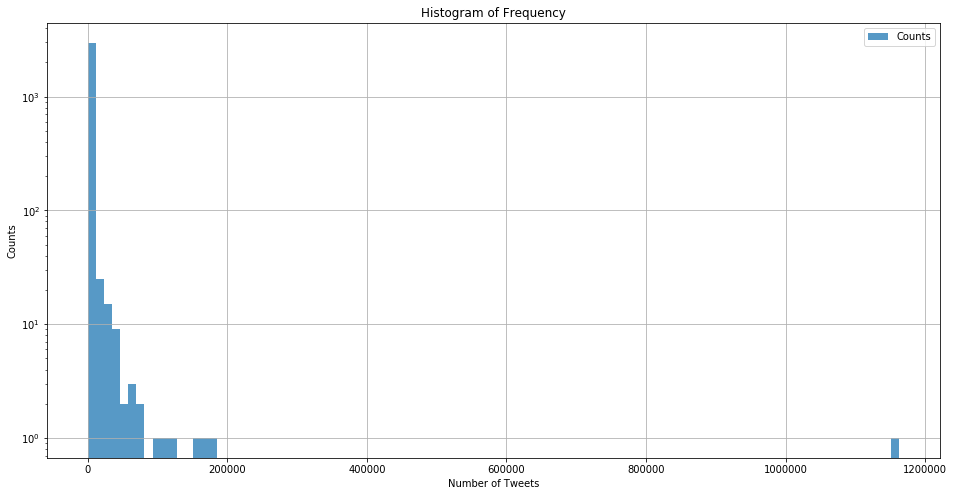

In [300]:
plt.figure(figsize=(16,8));
    
# the histogram of the data
plt.hist(
    [globalUserCounterQ4[x] for x in globalUserCounterQ4], 
    bins=100, 
    normed=0, 
    alpha=0.75,
    label="Counts",
    log=True);

plt.xlabel('Number of Tweets')
plt.ylabel('Counts')
plt.title("Histogram of Frequency")
plt.grid(True)
plt.legend();

plt.show();

**Question 5**. Study 3 users with the most posts. What were they tweeting about?

In [305]:
print ("Top Ten 3 Most Active User's posts:\n")
for currUser in sortedUsers[:3]:
    
    print "Account name:", currUser, "\ntweets:"
    
    for tweet in globalUserMap[currUser]:
        print tweet['text']

    print 

Top Ten 3 Most Active User's posts:

Account name: Young_Boss718 
tweets:
That random text  I had got be for LMFAO shit was funny
@MeerGotGame don't try and find shit lol
U inbox her on fb or text her
That wax museum is a fool in New York shit be real af
I kinda just felt when she just said idgaf lol
We be on the loud shit
Y'all be smoking that low volume
@BossBitchShxt chill out Monae you know I fucks with fab lol
I got my list tho 🙈🙉🙊
@The_Good_Fella9 it's ok
@NOFcks_Givn gave that head to ?
PART2
@The_Good_Fella9 word she's cool af
i wonder who had crush on me on twitter 😜😝😛😵
White girls don't have butts LMFAO
@BricksFromPluto lol
@SugarCocaine_ well I heard mad down south ppl say it that's why I ask
Getting alil sleepy
Moms gone for the whole night shit just about to smoke &amp; kick it with da homies
@LiyahhDoeee I know that's not you in them heels and skirt
@MikeyGotBudd I fucks with the mishka shirt fam
@Loud_Everyday 💯 already know
@She_Suckedd nigga shut up 😒
The pic jaida jus

<h3><strong>
    After examining the top 3 active twitter accounts I found they were twitter about the following:<br><br>
    @Young_Boss718: <br>Tweeting about their normal life, while it seems they were at the wax museum in NY at some point recently they didn't tweet about the hurricane at all from what I observed.<br><br>
    @Cocky_Johnny: <br> Tweeting about their daily/normal life mentioning their mother and grandmother with zero mention of the hurricane.<br><br>
    @frankieciv608 <br> This account was tweeting about the debates/politics with what may be a mention of the storm but seems to be referencing a past hurricane and not hurricane sandy so I'm not sure.
</strong></h3>

### Average Number of Posts

In [285]:
avgPostCount = np.mean([globalUserCounter[x] for x in globalUserCounter])
print "Average Number of Posts:", avgPostCount

Average Number of Posts: 1.4119000657462195


### Popular Hashtags

Hashtags give us a quick way to view the conversation and see what people are discussing. Getting the most popular hashtags is just as easy as getting the most prolific users.


In [195]:
# A map for hashtag counts
hashtagCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
            else:
                hashtagCounter[hashtagString] += 1

print ("Unique Hashtags:", len(hashtagCounter.keys()))
sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
print ("Top Twenty Hashtags:")
for ht in sortedHashtags[:20]:
    print ("\t", "#" + ht, hashtagCounter[ht])

('Unique Hashtags:', 997)
Top Twenty Hashtags:
('\t', u'#sandy', 108)
('\t', u'#nyc', 47)
('\t', u'#hurricanesandy', 26)
('\t', u'#newyork', 12)
('\t', u'#brooklyn', 9)
('\t', u'#hurricane', 8)
('\t', u'#halloween', 8)
('\t', u'#photooftheday', 8)
('\t', u'#frankenstorm', 8)
('\t', u'#instagood', 8)
('\t', u'#centralpark', 7)
('\t', u'#debates', 6)
('\t', u'#satstudytime', 6)
('\t', u'#instamood', 6)
('\t', u'#100thingsaboutme', 5)
('\t', u'#newyorkcity', 5)
('\t', u'#instagramhub', 5)
('\t', u'#igers', 5)
('\t', u'#instadaily', 5)
('\t', u'#studyingforthesat', 5)


### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.


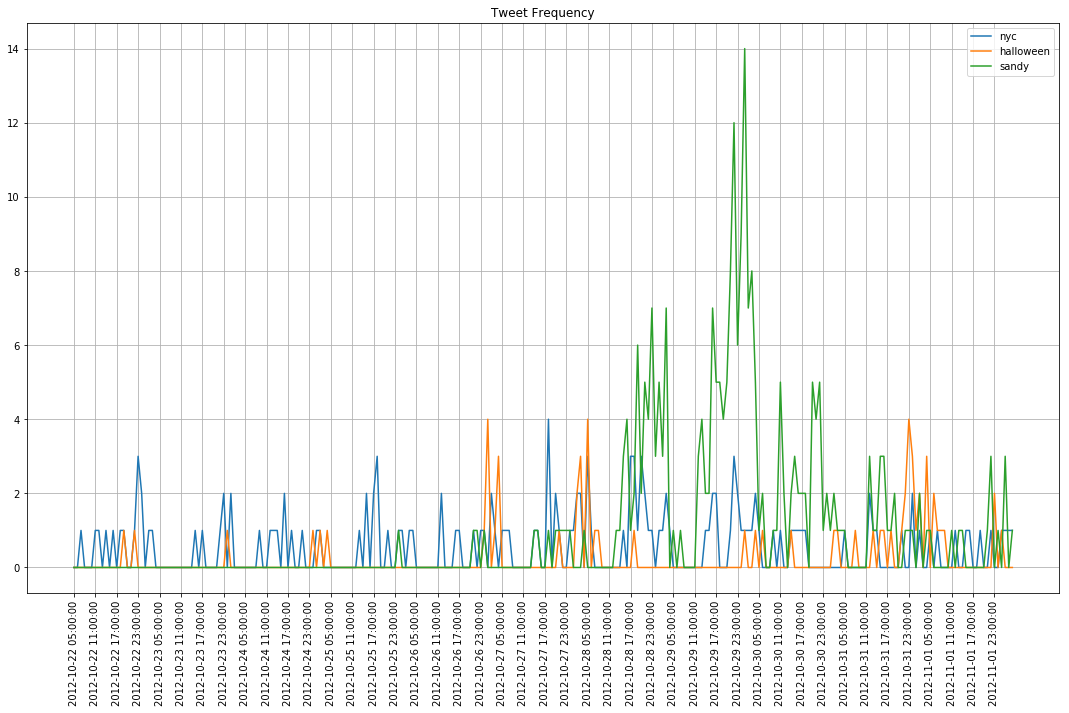

In [196]:
# What keywords are we interested in?
targetKeywords = ["nyc", "halloween"]
# targetKeywords.append("lowery")
# targetKeywords.append("reilly")
targetKeywords.append("sandy")


# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

#ax.plot(range(len(frequencyMap)), totalCount, label="Total")

for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Question 6**. Study some example codes with 2 different hashtags. Explain how are those messages different. 

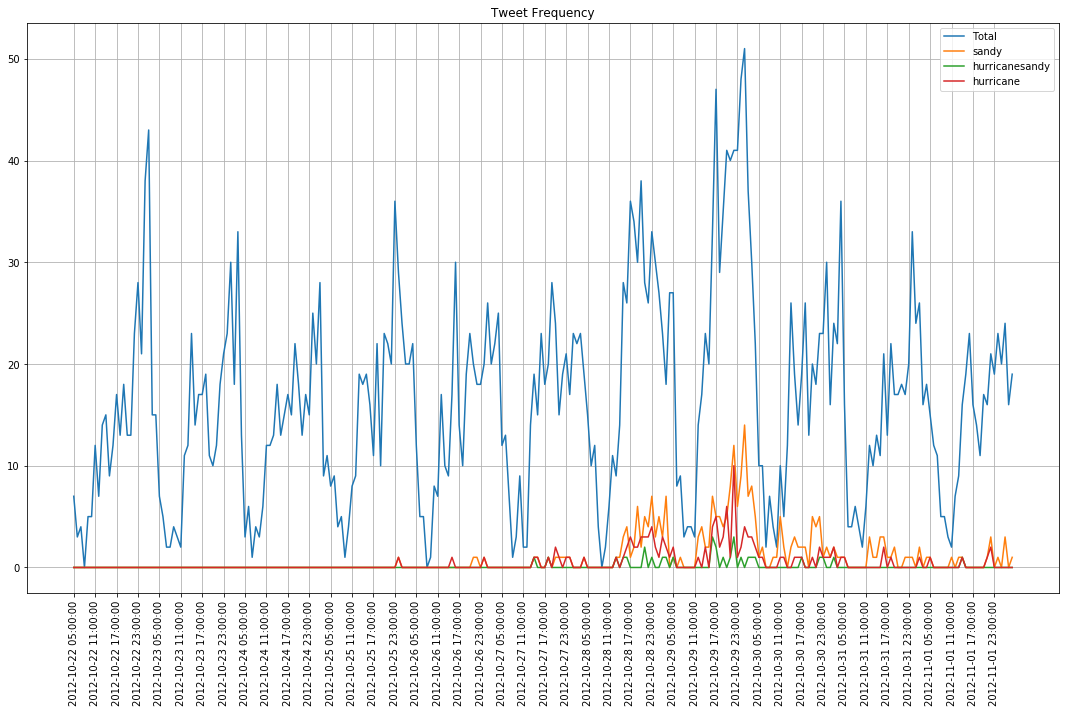

In [197]:
#this question is the most confusing thing I've read in a while.
sortedTimes6 = sorted(frequencyMap.keys())
sortedUsers6 = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)

targetKeywords6 = []
targetKeywords6.append("sandy")
targetKeywords6.append("hurricanesandy")
targetKeywords6.append("hurricane")


# Build an empty map for each keyword we are seaching for
targetCounts6 = {x:[] for x in targetKeywords6}
totalCount6 = []
#frequencyMap6 = {}

# For each minute, pull the tweet text and search for the keywords we want
for t6 in sortedTimes6:
    timeObj6 = frequencyMap[t6]
    
    # Temporary counter for this minute
    localTargetCounts6 = {x:0 for x in targetKeywords6}
    localTotalCount6 = 0
    
    for tweetObj6 in timeObj6["list"]:
        tweetString6 = tweetObj6["text"].lower()

        localTotalCount6 += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword6 in targetKeywords6:
            if ( keyword6 in tweetString6 ):
                localTargetCounts6[keyword6] += 1
                
    # Add the counts for this minute to the main counter
    totalCount6.append(localTotalCount6)
    for keyword6 in targetKeywords6:
        targetCounts6[keyword6].append(localTargetCounts6[keyword6])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes6[x] for x in smallerXTicks], rotation=90)

ax.plot(range(len(frequencyMap)), totalCount6, label="Total")


for keyword6 in targetKeywords6:
    ax.plot(range(len(frequencyMap)), targetCounts6[keyword6], label=keyword6);
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Question 7**. Which among the top 20 hashtags are related to Sandy. What are the most popular non-Sandy hashtags?

<h3>
    <strong>
        Top 20 hashtags related to Sandy:<br>  
        #sandy, 108<br>
        #hurricanesandy, 26<br>
        #hurricane, 8<br>
        #frankenstorm, 8<br>
        #nyc, 47<br>
        #newyork, 12<br>
        #brooklyn, 9<br>
        #newyorkcity, 5<br>
        #centralpark, 7<br>
        <br>
        Non-Sandy hashtags:<br>
        #halloween, 8<br>
        #photooftheday, 8<br>
        #instagood, 8<br>
        #debates, 6<br>
        #satstudytime, 6<br>
        #instamood, 6<br>
        #100thingsaboutme, 5<br>
        #instagramhub, 5<br>
        #igers, 5<br>
        #instadaily, 5<br>
        #studyingforthesat, 5<br>
        <br>
        <br>
    </strong>
    </h3>

**Question 8**. Among the top 20 hashtags, try to find which of them were particularly popular before Sandy, during Sandy, and those whose popularity did not change much. Try to apply k-means clustering on the time series of hashtags to try to find similar groups of hashtags. Discuss your findings.

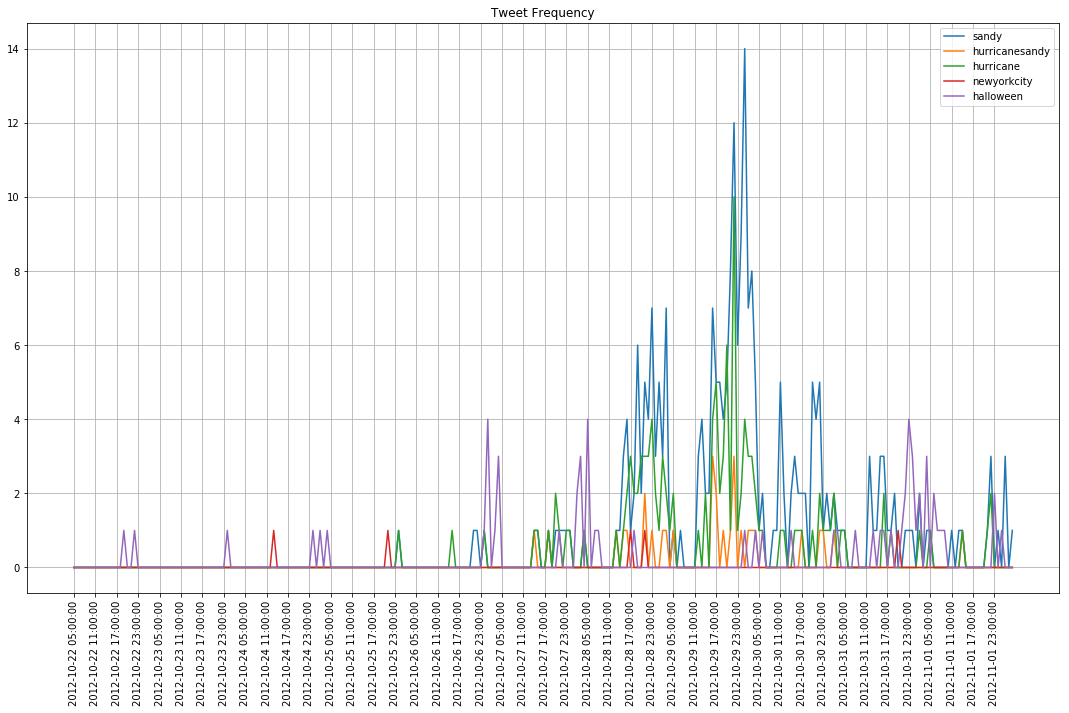

In [312]:
#Question 8:
#Among the top 20 hashtags, try to find which of them were particularly 
#popular before Sandy, during Sandy, and those whose popularity did not change much.

sortedTimes6 = sorted(frequencyMap.keys())
sortedUsers6 = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)

targetKeywords6 = []
targetKeywords6.append("sandy")
targetKeywords6.append("hurricanesandy")
targetKeywords6.append("hurricane")

targetKeywords6.append("newyorkcity")
targetKeywords6.append("halloween")

# Build an empty map for each keyword we are seaching for
targetCounts6 = {x:[] for x in targetKeywords6}
totalCount6 = []
#frequencyMap6 = {}

# For each minute, pull the tweet text and search for the keywords we want
for t6 in sortedTimes6:
    timeObj6 = frequencyMap[t6]
    
    # Temporary counter for this minute
    localTargetCounts6 = {x:0 for x in targetKeywords6}
    localTotalCount6 = 0
    
    for tweetObj6 in timeObj6["list"]:
        tweetString6 = tweetObj6["text"].lower()

        localTotalCount6 += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword6 in targetKeywords6:
            if ( keyword6 in tweetString6 ):
                localTargetCounts6[keyword6] += 1
                
    # Add the counts for this minute to the main counter
    totalCount6.append(localTotalCount6)
    for keyword6 in targetKeywords6:
        targetCounts6[keyword6].append(localTargetCounts6[keyword6])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes6[x] for x in smallerXTicks], rotation=90)

#ax.plot(range(len(frequencyMap)), totalCount6, label="Total")


for keyword6 in targetKeywords6:
    ax.plot(range(len(frequencyMap)), targetCounts6[keyword6], label=keyword6);
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

<h3>
    <strong>
        As shown in the graph above we can see that #newyorkcity stays unchanged in frequency throughout the sandy hurricane time span. In complete contrast #sandy, #hurricane got very popular before and during the time sandy was making landfall on the east coast. #hurricanesandy spiked in frequency, but nowhere near the popularity of sandy and hurricane. I was somewhat surprised that #newyorkcity and #halloween die in frequency compared to before the storm and after the storm especially since a lot of damage was happening in NY during this time that seems telling. 
    </strong>
    </h3>

In [316]:
#Question 8 k-means
#Didnt get to finish this part

### Language Distribution

The following code gives an insight into the languages used for the tweets in your data.


In [200]:
# A map for counting each language
languageCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        lang = tweet["lang"]
        
        if ( lang not in languageCounter ):
            languageCounter[lang] = 1
        else:
            languageCounter[lang] += 1
            
languages = sorted(languageCounter.keys(), key=languageCounter.get, reverse=True)

for l in languages:
    print (l, languageCounter[l])

(u'en', 3688)
(u'es', 192)
(u'und', 162)
(u'tl', 29)
(u'fr', 27)
(u'pt', 24)
(u'ar', 20)
(u'tr', 20)
(u'ht', 20)
(u'ru', 18)
(u'it', 16)
(u'in', 16)
(u'nl', 6)
(u'de', 6)
(u'ja', 6)
(u'sv', 5)
(u'pl', 4)
(u'fi', 4)
(u'ko', 4)
(u'lv', 3)
(u'ro', 3)
(u'hi', 3)
(u'vi', 2)
(u'is', 2)
(u'cy', 2)
(u'cs', 2)
(u'et', 2)
(u'da', 2)
(u'sl', 2)
(u'zh', 1)
(u'eu', 1)
(u'lt', 1)
(u'fa', 1)
(u'hu', 1)


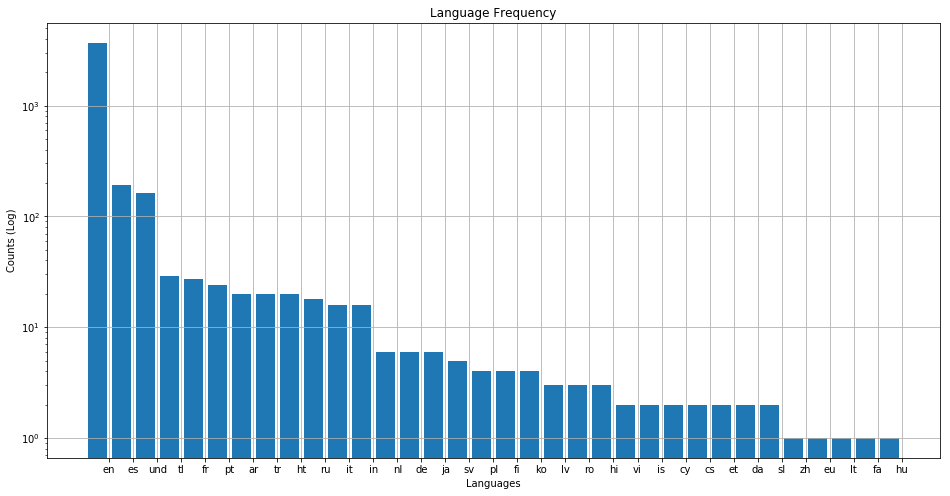

In [201]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.bar(
    np.arange(len(languages)),
    [languageCounter[x] for x in languages],
    log=True)

plt.xticks(np.arange(len(languages)) + 0.5, languages)
plt.xlabel('Languages')
plt.ylabel('Counts (Log)')
plt.title("Language Frequency")
plt.grid(True)

plt.show()

**Quesiton 9**. Now that you have experience in extracting different types of information from twitter data, perform your own EDA. Produce a 1-page report providing some interesting insights about the Sandy twitter data.

In [202]:
#in separate file

## Module 2: Classification

In this part of the lab, we will work on a binary classificaiton problem. In particular, we would like to see how easy it is to discriminate between tweets with hashtag #sandy and the rest of them. To do it, we will first create labels: positive tweets will be those with hashtag #sandy and negative those without the hashtag. Then, we we will create a bag-of-words vector out of each tweet, but we will exclude word "#sandy". To produce the bag-of-words representation we will use the `CountVectorizer` functionality 

In [203]:
import pandas as pd
import numpy as np
import codecs, json

"""
Step 1. Create sentences and labels from json file. 
"""
filePath='smallNYC.json'
sents = []
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    sents.append(tweetObj['text'])
    
"""
Step 2.1. Get label. If sent contains '#sandy', label=1; otherwise, label=0
"""
labels = np.array(['#sandy' in sent.split() for sent in sents], dtype='int')
print(pd.Series(labels).value_counts())
"""
Step 2.2. Represent the data into Bag-of-words features, i.e, each sentence is a 
            vector of word counts. 
          a). Only select words with frequency >= 5
          b). Remove label words '#sandy'
"""

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words = ['#sandy'])
features = vectorizer.fit_transform(sents)


print('#sandy' in vectorizer.get_feature_names())
print(features.toarray())
print(vectorizer.get_feature_names());

0    4234
1      61
dtype: int64
False
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[u'00', u'10', u'100thingsaboutme', u'12', u'13', u'14', u'15', u'16', u'18', u'20', u'2012', u'21', u'24', u'26', u'28', u'2nd', u'30', u'40', u'50', u'6th', u'able', u'about', u'actually', u'ads', u'adventure', u'af', u'after', u'afternoon', u'again', u'against', u'ago', u'ain', u'air', u'airport', u'al', u'album', u'alert', u'alive', u'all', u'almost', u'already', u'also', u'always', u'am', u'amazing', u'america', u'american', u'amp', u'an', u'and', u'another', u'any', u'anyone', u'anything', u'anyway', u'apartment', u'apocalypse', u'app', u'apple', u'appreciate', u'aqui', u'are', u'area', u'aren', u'around', u'art', u'as', u'ask', u'asked', u'asleep', u'ass', u'astoria', u'at', u'ave', u'avenue', u'away', u'awesome', u'awkward', u'aww', u'awww', u'babe', u'baby', u'back', u'bacon', u'bad', u'ballroom', u'bar', u'barclays', u'

**Quesiton 10**. Given the data set of labeled tweets, you have to train a classification model and check the accuracy. Remember to first split the data into training and test. You should explore kNN classification, decision tree classification, Random Forest classification.

In [204]:
#this example was in the code already 
"""
Step 3. Divide data into train and test 
"""
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42) 

clf = LogisticRegression()
start_time = time.time()
clf.fit(X_train, y_train)
print('Time for %s fitting: %.3f' % ('LogisticRegression', time.time() - start_time))
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc));

Time for LogisticRegression fitting: 0.010
Test Perf ACC: 0.988, AUC: 0.986


In [205]:
#question 10 kNN classification
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

classf = KNeighborsClassifier()

start_kNN = time.time()

classf.fit(X_train, y_train)

print "Fitting time for %s was %.6f" % ('KNeighborsClassifier', (time.time() - start_kNN))

acc_kNN = classf.score(X_test, y_test)

y_pred_prob = classf.predict_proba(X_test)[:, 1]
auc_kNN = roc_auc_score(y_test, y_pred_prob)
print('\nTest Perf ACC: %.3f, AUC: %.3f' %(acc_kNN, auc_kNN));

Fitting time for KNeighborsClassifier was 0.000793

Test Perf ACC: 0.988, AUC: 0.774


In [206]:
#question 10 decision tree classification
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

classf_D = DecisionTreeClassifier()
start_D = time.time()
classf_D.fit(X_train, y_train)

print "Fitting time for %s was %.6f" % ('DecisionTreeClassifier', (time.time() - start_D))

acc_D = classf_D.score(X_test, y_test)

y_pred_prob = classf_D.predict_proba(X_test)[:, 1]
auc_D = roc_auc_score(y_test, y_pred_prob)
print('\nTest Perf ACC: %.3f, AUC: %.3f' %(acc_D, auc_D));

Fitting time for DecisionTreeClassifier was 0.005533

Test Perf ACC: 0.982, AUC: 0.682


In [207]:
#question 10 Random Forest classification
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

classf_R = RandomForestClassifier()
start_R = time.time()
classf_R.fit(X_train, y_train)

print "Fitting time for %s was %.6f" % ('DecisionTreeClassifier', (time.time() - start_R))

acc_R = classf_R.score(X_test, y_test)

y_pred_prob = classf.predict_proba(X_test)[:, 1]
auc_R = roc_auc_score(y_test, y_pred_prob)
print('\nTest Perf ACC: %.3f, AUC: %.3f' %(acc_R, auc_R));

Fitting time for DecisionTreeClassifier was 0.044892

Test Perf ACC: 0.989, AUC: 0.774


**Question 11**. Train the so-called *Logistic regression classifier* and check its accuracy. Compare with the results from *Question 10*. The following lines of code will be useful to do it.

In [208]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

classf_LR = LogisticRegression()
start_LR = time.time()
classf_LR.fit(X_train, y_train)

print "Fitting time for %s was %.6f" % ('LogisticRegression', (time.time() - start_LR))

acc_LR = classf_LR.score(X_test, y_test)

y_pred_prob = classf.predict_proba(X_test)[:, 1]
auc_LR = roc_auc_score(y_test, y_pred_prob)
print('\nTest Perf ACC: %.3f, AUC: %.3f' %(acc_LR, auc_LR));

Fitting time for LogisticRegression was 0.009073

Test Perf ACC: 0.988, AUC: 0.774


<h3>
<strong>
    It seems like logistic regression needed a little less than double the time the RandomForest needed, while retaining roughly the same ACC and AUC. 
</strong>
</h3>

# Module 3. Extra Credit: Using API to Download Tweets (50 extra points)

To run the following code you will need to install the `tweepy` package.

* Create a twitter account if you do not already have one
* Go to https://apps.twitter.com/ and log in with your twitter credentials.
* Click 'Create New App'
* Fill out the Name, Description, Website fields and agree the terms. Put in any website you want if you don't have one you want to use.
* On the next page, click the 'Keys and Access Tokens' tab along the top, then scroll all the way down until you see the section 'Your Access Token
* Click the button 'Create My Access Token'.
* You will now copy four values below. These values are your 'Consumer Key (API Key)', your 'Consumer Secret (API Secret)', your 'Access token' and your 'Access token secret'. All four should now be visible on the 'Keys and Access Tokens' page. Set the variables corresponding to the API key, API secret, access token, and access secret. You will see code like the below:


In [224]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json, sys
import codecs



ckey = "huXUcF3Dcdj6d50zSZjS4qQEu"
csecret = "tStZUMXYLtBWBQme7VHltytv2Vv97dMagxuA2XnuwkPEjzPzEI"
atoken = "1113174684772827141-OWv2sNJ0xk582VJ3129G4cxRGk2nCZ"
asecret = "BWTK5poMxqARBbKzGDAh4Uy3GGopyV4sQUAz0xvG45HAK"

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

output = codecs.open('twitter_data.json', 'wb', encoding='utf-8')
line_num = 0
count = 0
while count < 100:
    class CustomStreamListener(StreamListener):
        def on_status(self, status):
            print status.text
        print "hello"
        def on_data(self, data):
            json_data = json.loads(data)
            output.write(str(json_data))
            output.write("\n")

        def on_error(self, status_code):
            print sys.stderr, 'Encountered error with status code:', status_code
            return True # Don't kill the stream

        def on_timeout(self):
            print sys.stderr, 'Timeout...'
            return True # Don't kill the stream

hello


KeyboardInterrupt: 

The following line of code allows you to download the current stream of codes that contain word *basketball*.

In [210]:
twitterStream = Stream(auth, CustomStreamListener())
twitterStream.filter(track=['basketball'])

KeyboardInterrupt: 

You can stop downloading by terminating the process (the stop button in Jupiter menu)

Now you can also filter Tweets by locations by setting the parameters in filter.
By setting the filter(locations = [-75.280291,39.867005,-74.955831,40.137959]), you will
get all tweets from Philadelphia. To get bounding box for other areas, the klokantech's tool can
be used. 
To learn more about Twitter Stream API parameters, please go to: 
    https://dev.twitter.com/streaming/overview/request-parameters 
    
** Extra point Question**. Pick you favorite geographical region, keyword, or a hashtag and download at least 1,000 tweets. Perform any kind of exploratory or predictive data analysis that you find interesting and produce a 2-page report summarizing what you did and why and explaining what kind of results nd insights you obtained.



In [319]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json, sys
import codecs



ckey = "huXUcF3Dcdj6d50zSZjS4qQEu"
csecret = "tStZUMXYLtBWBQme7VHltytv2Vv97dMagxuA2XnuwkPEjzPzEI"
atoken = "1113174684772827141-OWv2sNJ0xk582VJ3129G4cxRGk2nCZ"
asecret = "BWTK5poMxqARBbKzGDAh4Uy3GGopyV4sQUAz0xvG45HAK"

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

output = codecs.open('twitter_data.json', 'wb', encoding='utf-8')
line_num = 0
count = 0
while count < 100:
    class CustomStreamListener(StreamListener):
        def on_status(self, status):
            print status.text
            
        def on_data(self, data):
            json_data = json.loads(data)
            output.write(str(json_data))
            output.write("\n")

        def on_error(self, status_code):
            print sys.stderr, 'Encountered error with status code:', status_code
            return True # Don't kill the stream

        def on_timeout(self):
            print sys.stderr, 'Timeout...'
            return True # Don't kill the stream
        
        twitterStream = Stream(auth, CustomStreamListener())
        twitterStream.filter(locations = [-75.280291,39.867005,-74.955831,40.137959])

KeyboardInterrupt: 